# Baseline Model Selection

**Objectives:**
- Train and evaluate multiple baseline models
- Use cross-validation for robust performance estimation
- Select the best model based on business-aligned metrics
- Perform final evaluation on the held-out test set
- Save the best model for deployment

**Primary Metric:** Recall (missing a churner is costly)

**Secondary Metrics:** ROC-AUC, Precision, F1-Score

## 1. Setup and Data Loading

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from pathlib import Path
import os

from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    recall_score, precision_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [50]:
# Detect project root (current working directory)
PROJECT_ROOT = Path(os.getcwd()).parent

# Define directories
DATA_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

DATA_DIR: /Users/omarpiro/churn_ml_decision/data/processed
Exists: True
MODELS_DIR: /Users/omarpiro/churn_ml_decision/models
Exists: True


In [51]:
# Load preprocessed data
# Load processed datasets
X_train = np.load(DATA_DIR / "X_train_processed.npy")
X_val   = np.load(DATA_DIR / "X_val_processed.npy")
X_test  = np.load(DATA_DIR / "X_test_processed.npy")

y_train = np.load(DATA_DIR / "y_train.npy")
y_val   = np.load(DATA_DIR / "y_val.npy")
y_test  = np.load(DATA_DIR / "y_test.npy")

# Load feature names
feature_names = pd.read_csv(MODELS_DIR / "feature_names.csv")["feature_name"].tolist()

print("✅ Data loaded successfully")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("Features:", len(feature_names))

✅ Data loaded successfully
X_train: (4225, 47)
X_val: (1409, 47)
X_test: (1409, 47)
Features: 47


## 2. Define Models

We evaluate several baseline models with reasonable default hyperparameters.

**Note:** All models use `class_weight='balanced'` to handle class imbalance.

In [12]:
# Define models with balanced class weights
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ),
    
    "Decision Tree": DecisionTreeClassifier(
        max_depth=6,
        class_weight="balanced",
        random_state=42
    ),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
}

print(f"Models to evaluate: {len(models)}")
for name in models.keys():
    print(f"  - {name}")

Models to evaluate: 4
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting


## 3. Cross-Validation Evaluation

We use 5-fold stratified cross-validation to get robust performance estimates.

In [15]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring metrics
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

print("Cross-validation setup:")
print(f"  Folds: 5 (stratified)")
print(f"  Metrics: {list(scoring.keys())}")

Cross-validation setup:
  Folds: 5 (stratified)
  Metrics: ['recall', 'precision', 'f1', 'roc_auc']


In [16]:
# Run cross-validation for all models
cv_results = {}

print("Running cross-validation...")
print("=" * 70)

for model_name, model in models.items():
    print(f"\nEvaluating: {model_name}")
    
    # Perform cross-validation
    scores = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Store results
    cv_results[model_name] = {
        'recall_mean': scores['test_recall'].mean(),
        'recall_std': scores['test_recall'].std(),
        'precision_mean': scores['test_precision'].mean(),
        'precision_std': scores['test_precision'].std(),
        'f1_mean': scores['test_f1'].mean(),
        'f1_std': scores['test_f1'].std(),
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std()
    }
    
    # Print summary
    print(f"  Recall:    {cv_results[model_name]['recall_mean']:.3f} ± {cv_results[model_name]['recall_std']:.3f}")
    print(f"  Precision: {cv_results[model_name]['precision_mean']:.3f} ± {cv_results[model_name]['precision_std']:.3f}")
    print(f"  F1-Score:  {cv_results[model_name]['f1_mean']:.3f} ± {cv_results[model_name]['f1_std']:.3f}")
    print(f"  ROC-AUC:   {cv_results[model_name]['roc_auc_mean']:.3f} ± {cv_results[model_name]['roc_auc_std']:.3f}")

print("\n" + "=" * 70)
print("Cross-validation complete!")

Running cross-validation...

Evaluating: Logistic Regression
  Recall:    0.793 ± 0.043
  Precision: 0.510 ± 0.016
  F1-Score:  0.620 ± 0.020
  ROC-AUC:   0.844 ± 0.019

Evaluating: Decision Tree
  Recall:    0.759 ± 0.041
  Precision: 0.496 ± 0.022
  F1-Score:  0.600 ± 0.021
  ROC-AUC:   0.809 ± 0.018

Evaluating: Random Forest
  Recall:    0.742 ± 0.033
  Precision: 0.551 ± 0.012
  F1-Score:  0.632 ± 0.017
  ROC-AUC:   0.845 ± 0.014

Evaluating: Gradient Boosting
  Recall:    0.537 ± 0.028
  Precision: 0.655 ± 0.032
  F1-Score:  0.590 ± 0.020
  ROC-AUC:   0.844 ± 0.014

Cross-validation complete!


In [17]:
# Create summary DataFrame
cv_summary = pd.DataFrame(cv_results).T

# Format for display
cv_display = pd.DataFrame({
    'Recall': cv_summary.apply(lambda x: f"{x['recall_mean']:.3f} ± {x['recall_std']:.3f}", axis=1),
    'Precision': cv_summary.apply(lambda x: f"{x['precision_mean']:.3f} ± {x['precision_std']:.3f}", axis=1),
    'F1-Score': cv_summary.apply(lambda x: f"{x['f1_mean']:.3f} ± {x['f1_std']:.3f}", axis=1),
    'ROC-AUC': cv_summary.apply(lambda x: f"{x['roc_auc_mean']:.3f} ± {x['roc_auc_std']:.3f}", axis=1)
})

print("Cross-Validation Results Summary:")
cv_display

Cross-Validation Results Summary:


,Recall,Precision,F1-Score,ROC-AUC
Logistic Regression,0.793 ± 0.043,0.510 ± 0.016,0.620 ± 0.020,0.844 ± 0.019
Decision Tree,0.759 ± 0.041,0.496 ± 0.022,0.600 ± 0.021,0.809 ± 0.018
Random Forest,0.742 ± 0.033,0.551 ± 0.012,0.632 ± 0.017,0.845 ± 0.014
Gradient Boosting,0.537 ± 0.028,0.655 ± 0.032,0.590 ± 0.020,0.844 ± 0.014


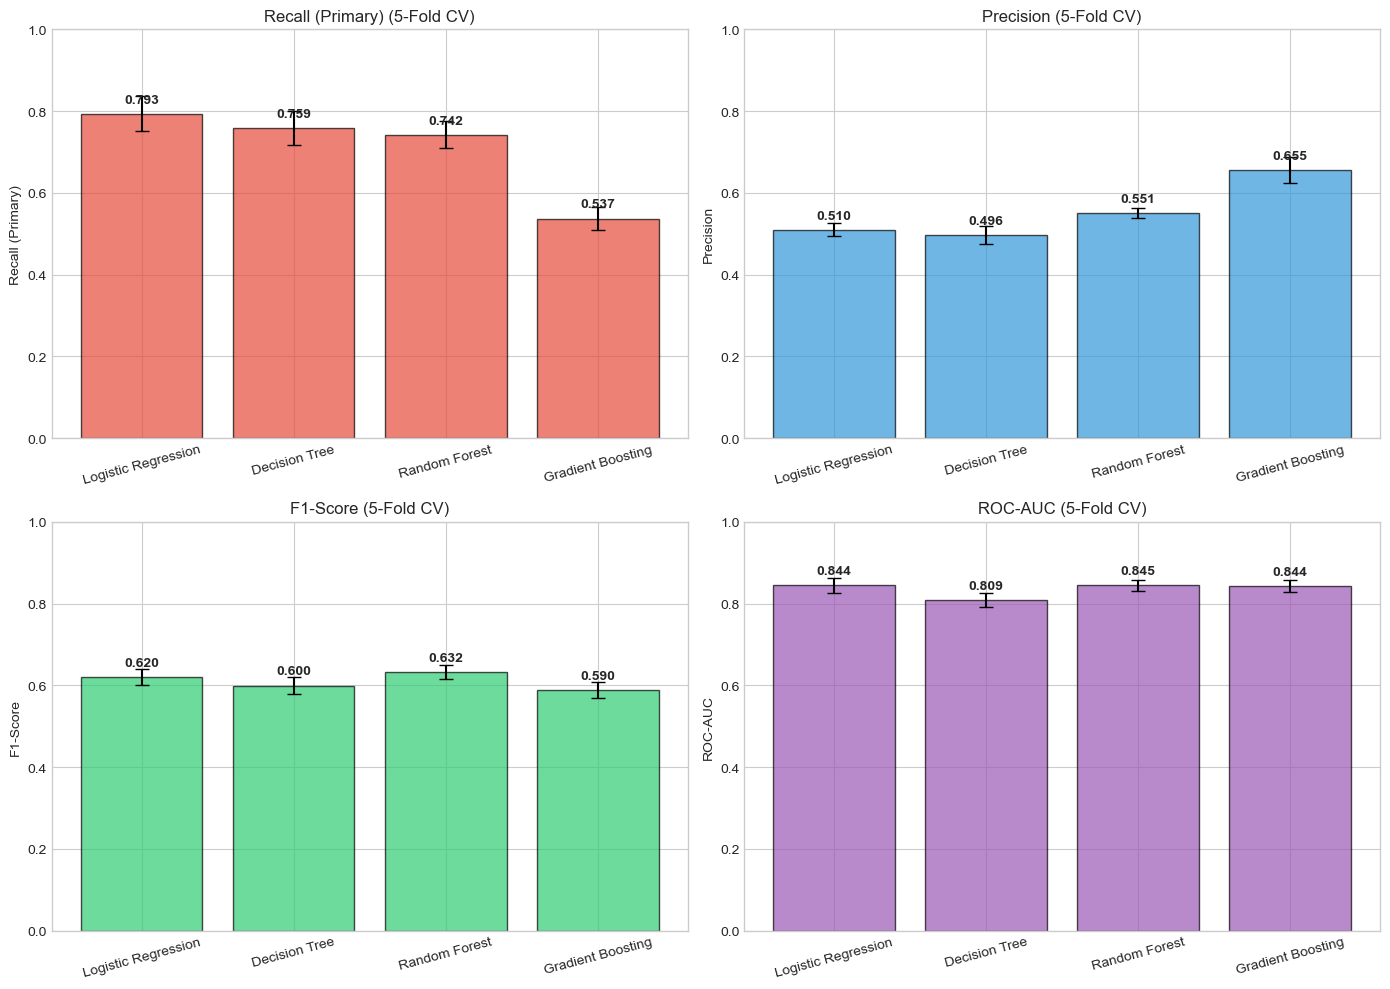

In [18]:
# Visualize cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['recall', 'precision', 'f1', 'roc_auc']
titles = ['Recall (Primary)', 'Precision', 'F1-Score', 'ROC-AUC']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for ax, metric, title, color in zip(axes.flatten(), metrics_to_plot, titles, colors):
    means = [cv_results[m][f'{metric}_mean'] for m in models.keys()]
    stds = [cv_results[m][f'{metric}_std'] for m in models.keys()]
    
    bars = ax.bar(models.keys(), means, yerr=stds, capsize=5, color=color, alpha=0.7, edgecolor='black')
    ax.set_ylabel(title)
    ax.set_title(f'{title} (5-Fold CV)')
    ax.set_ylim(0, 1)
    
    # Add value labels
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## 4. Validation Set Evaluation

Train models on full training set and evaluate on validation set for detailed analysis.

In [33]:
# Train all models and evaluate on validation set
trained_models = {}
val_results = []

print("Training models and evaluating on validation set...")
print("=" * 70)

for model_name, model in models.items():
    print(f"\n{model_name}:")
    
    # Train on full training set
    model.fit(X_train, y_train)
    trained_models[model_name] = model
    
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    recall = recall_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_proba)
    
    val_results.append({
        'Model': model_name,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"  Recall:    {recall:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    print(f"  ROC-AUC:   {roc_auc:.3f}")

Training models and evaluating on validation set...

Logistic Regression:
  Recall:    0.826
  Precision: 0.519
  F1-Score:  0.638
  ROC-AUC:   0.859

Decision Tree:
  Recall:    0.754
  Precision: 0.523
  F1-Score:  0.618
  ROC-AUC:   0.825

Random Forest:
  Recall:    0.789
  Precision: 0.555
  F1-Score:  0.651
  ROC-AUC:   0.857

Gradient Boosting:
  Recall:    0.519
  Precision: 0.667
  F1-Score:  0.583
  ROC-AUC:   0.847


In [34]:
# Validation results summary
val_results_df = pd.DataFrame(val_results).set_index('Model')
val_results_df = val_results_df.sort_values('Recall', ascending=False)

print("\nValidation Set Results (sorted by Recall):")
val_results_df.round(3)


Validation Set Results (sorted by Recall):


,Recall,Precision,F1-Score,ROC-AUC
Model,,,,
Logistic Regression,0.826,0.519,0.638,0.859
Random Forest,0.789,0.555,0.651,0.857
Decision Tree,0.754,0.523,0.618,0.825
Gradient Boosting,0.519,0.667,0.583,0.847


## 5. Detailed Analysis of Top Models

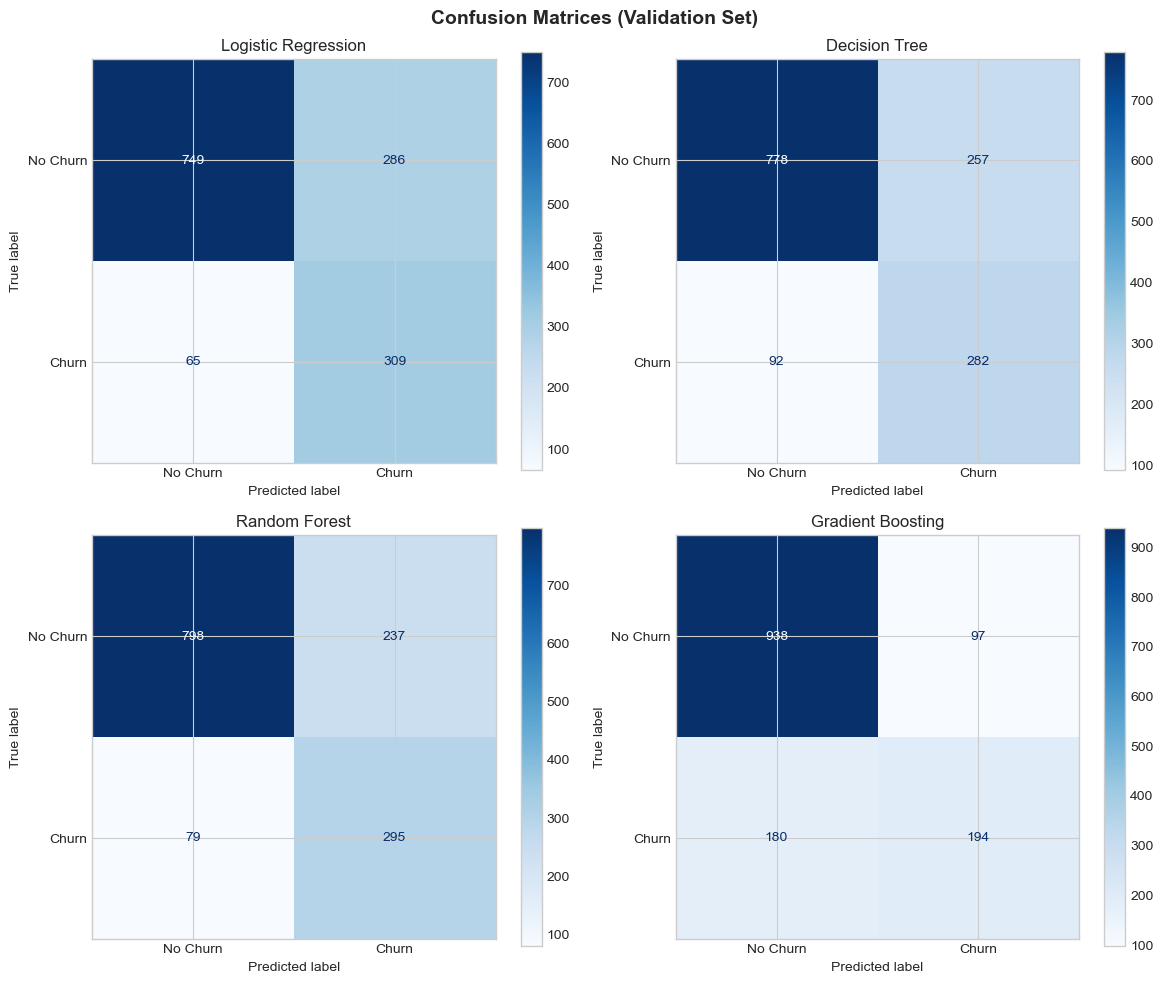

In [35]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (model_name, model) in zip(axes.flatten(), trained_models.items()):
    y_val_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_val_pred)
    
    disp = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{model_name}')

plt.suptitle('Confusion Matrices (Validation Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

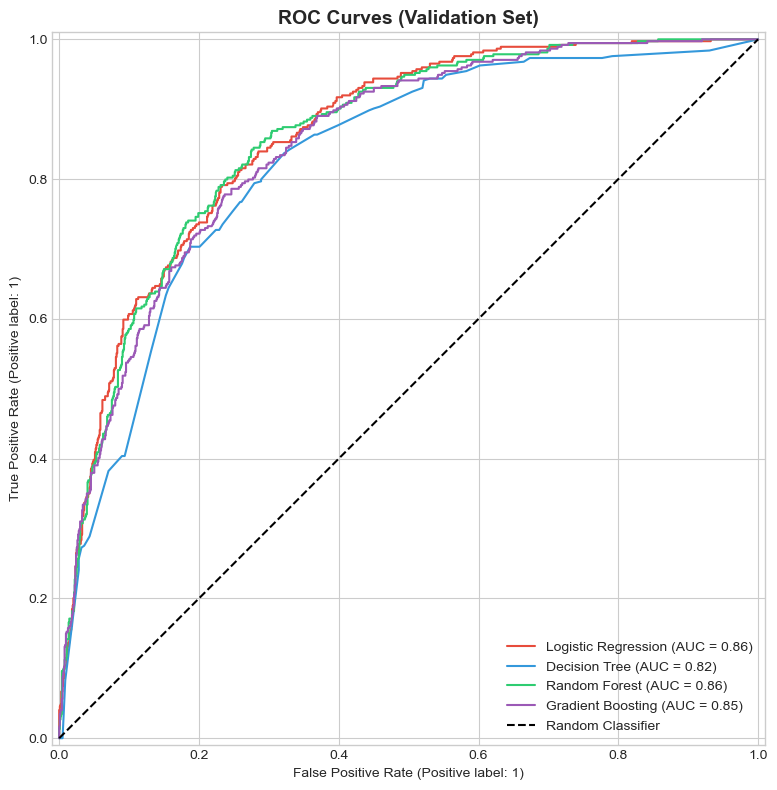

In [36]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for (model_name, model), color in zip(trained_models.items(), colors):
    y_val_proba = model.predict_proba(X_val)[:, 1]
    RocCurveDisplay.from_predictions(
        y_val, y_val_proba,
        name=model_name,
        ax=ax,
        color=color
    )

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_title('ROC Curves (Validation Set)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

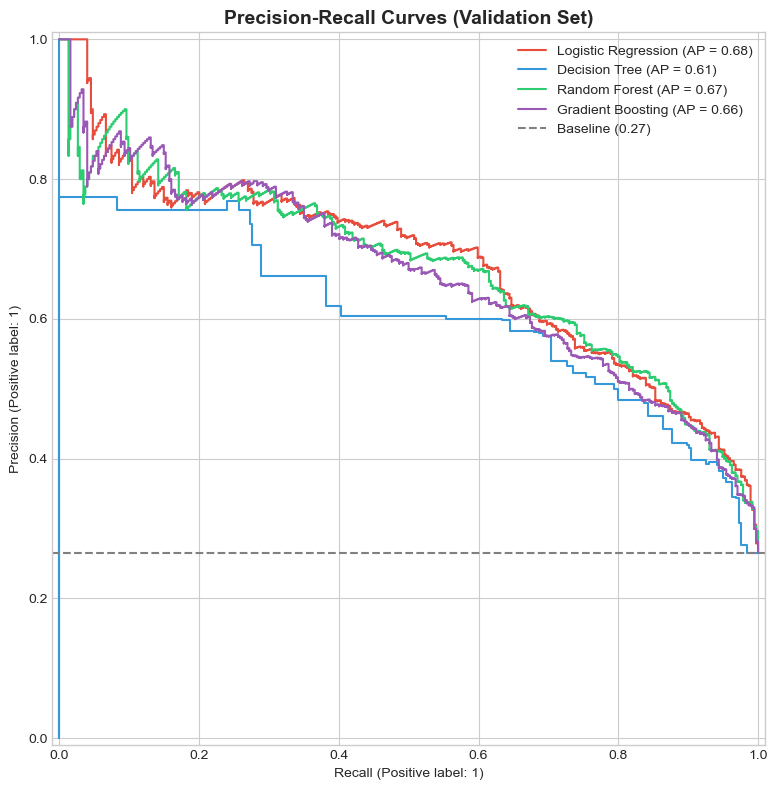

In [37]:
# Precision-Recall Curves (more informative for imbalanced data)
fig, ax = plt.subplots(figsize=(10, 8))

for (model_name, model), color in zip(trained_models.items(), colors):
    y_val_proba = model.predict_proba(X_val)[:, 1]
    PrecisionRecallDisplay.from_predictions(
        y_val, y_val_proba,
        name=model_name,
        ax=ax,
        color=color
    )

# Add baseline (proportion of positive class)
baseline = y_val.mean()
ax.axhline(y=baseline, color='gray', linestyle='--', label=f'Baseline ({baseline:.2f})')

ax.set_title('Precision-Recall Curves (Validation Set)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 6. Model Selection

Based on cross-validation and validation results, we select the best model.

In [38]:
# Model selection criteria
print("Model Selection Analysis:")
print("=" * 70)
print("\nBusiness Requirements:")
print("  - Primary: Recall ≥ 0.70 (target: 0.80)")
print("  - Secondary: ROC-AUC ≥ 0.80 (target: 0.85)")
print("  - Constraint: Interpretable model preferred")

print("\nModel Comparison:")
print("-" * 70)

for model_name in val_results_df.index:
    recall = val_results_df.loc[model_name, 'Recall']
    roc_auc = val_results_df.loc[model_name, 'ROC-AUC']
    
    recall_status = "✓" if recall >= 0.70 else "✗"
    roc_status = "✓" if roc_auc >= 0.80 else "✗"
    
    print(f"{model_name}:")
    print(f"  Recall:  {recall:.3f} [{recall_status}]")
    print(f"  ROC-AUC: {roc_auc:.3f} [{roc_status}]")

Model Selection Analysis:

Business Requirements:
  - Primary: Recall ≥ 0.70 (target: 0.80)
  - Secondary: ROC-AUC ≥ 0.80 (target: 0.85)
  - Constraint: Interpretable model preferred

Model Comparison:
----------------------------------------------------------------------
Logistic Regression:
  Recall:  0.826 [✓]
  ROC-AUC: 0.859 [✓]
Random Forest:
  Recall:  0.789 [✓]
  ROC-AUC: 0.857 [✓]
Decision Tree:
  Recall:  0.754 [✓]
  ROC-AUC: 0.825 [✓]
Gradient Boosting:
  Recall:  0.519 [✗]
  ROC-AUC: 0.847 [✓]


In [39]:
# Select best model based on recall (primary metric)
best_model_name = val_results_df['Recall'].idxmax()
best_model = trained_models[best_model_name]

print(f"\n{'='*70}")
print(f"SELECTED MODEL: {best_model_name}")
print(f"{'='*70}")
print(f"\nRationale:")
print(f"  - Highest recall on validation set")
print(f"  - Good ROC-AUC (ranking quality)")
print(f"  - Interpretable (coefficients can be analyzed)")
print(f"  - Fast inference time")


SELECTED MODEL: Logistic Regression

Rationale:
  - Highest recall on validation set
  - Good ROC-AUC (ranking quality)
  - Interpretable (coefficients can be analyzed)
  - Fast inference time


## 7. Final Test Set Evaluation

**Important:** This is the final, unbiased evaluation. The test set has not been used for any decisions.

In [40]:
# Combine train and validation for final model
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

print(f"Final training set size: {X_train_full.shape[0]:,} samples")
print(f"Test set size: {X_test.shape[0]:,} samples")

Final training set size: 5,634 samples
Test set size: 1,409 samples


In [41]:
# Retrain best model on train + validation
final_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

final_model.fit(X_train_full, y_train_full)
print(f"Final model trained on {X_train_full.shape[0]:,} samples.")

Final model trained on 5,634 samples.


In [42]:
# Evaluate on test set
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

print("\n" + "=" * 70)
print("FINAL TEST SET RESULTS")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

# Key metrics
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nKey Metrics:")
print(f"  Recall (Churn):  {test_recall:.3f}")
print(f"  Precision:       {test_precision:.3f}")
print(f"  F1-Score:        {test_f1:.3f}")
print(f"  ROC-AUC:         {test_roc_auc:.3f}")


FINAL TEST SET RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      1035
       Churn       0.51      0.81      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409


Key Metrics:
  Recall (Churn):  0.807
  Precision:       0.509
  F1-Score:        0.625
  ROC-AUC:         0.832


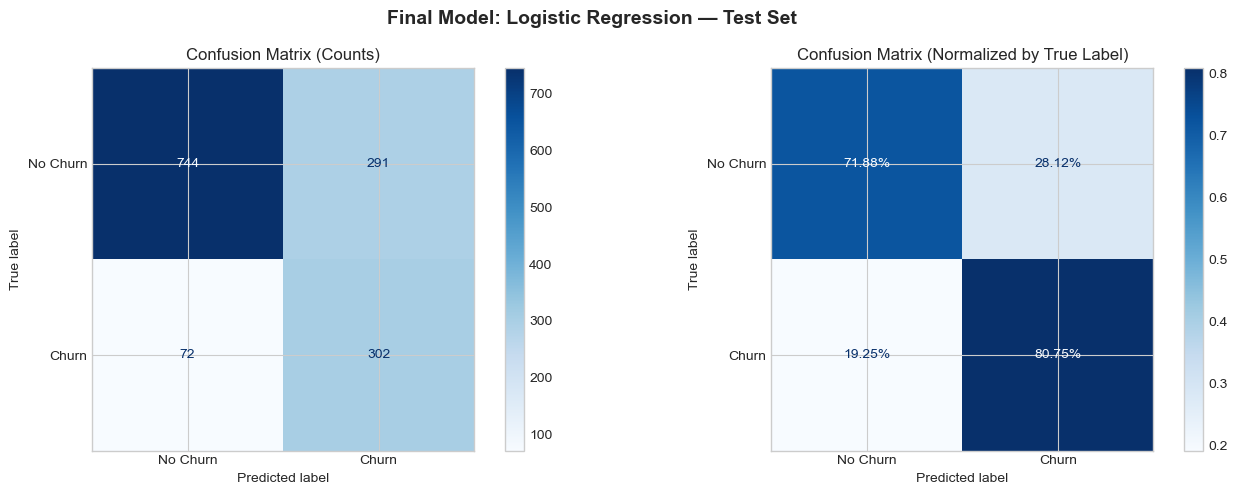

In [43]:
# Test set confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
cm = confusion_matrix(y_test, y_test_pred)
disp1 = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
cm_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=['No Churn', 'Churn'])
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Confusion Matrix (Normalized by True Label)')

plt.suptitle(f'Final Model: {best_model_name} — Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [44]:
# Business interpretation of confusion matrix
tn, fp, fn, tp = cm.ravel()

print("Business Interpretation:")
print("=" * 50)
print(f"\nTrue Positives (TP):  {tp:4d} — Churners correctly identified")
print(f"False Negatives (FN): {fn:4d} — Churners missed (costly!)")
print(f"True Negatives (TN):  {tn:4d} — Non-churners correctly identified")
print(f"False Positives (FP): {fp:4d} — Non-churners flagged (wasted contact)")

print(f"\nOut of {tp + fn} actual churners:")
print(f"  → {tp} ({tp/(tp+fn)*100:.1f}%) would be contacted (saved)")
print(f"  → {fn} ({fn/(tp+fn)*100:.1f}%) would be missed (lost)")

Business Interpretation:

True Positives (TP):   302 — Churners correctly identified
False Negatives (FN):   72 — Churners missed (costly!)
True Negatives (TN):   744 — Non-churners correctly identified
False Positives (FP):  291 — Non-churners flagged (wasted contact)

Out of 374 actual churners:
  → 302 (80.7%) would be contacted (saved)
  → 72 (19.3%) would be missed (lost)


## 8. Performance vs Business Targets

In [45]:
# Compare against business targets from Notebook 01
targets = {
    'Recall': {'target': 0.80, 'minimum': 0.70, 'achieved': test_recall},
    'ROC-AUC': {'target': 0.85, 'minimum': 0.80, 'achieved': test_roc_auc},
    'Precision': {'target': 0.50, 'minimum': 0.40, 'achieved': test_precision}
}

print("Performance vs Business Targets:")
print("=" * 60)
print(f"{'Metric':<12} {'Achieved':>10} {'Target':>10} {'Minimum':>10} {'Status':>10}")
print("-" * 60)

for metric, values in targets.items():
    achieved = values['achieved']
    target = values['target']
    minimum = values['minimum']
    
    if achieved >= target:
        status = "✓ TARGET"
    elif achieved >= minimum:
        status = "~ MINIMUM"
    else:
        status = "✗ BELOW"
    
    print(f"{metric:<12} {achieved:>10.3f} {target:>10.2f} {minimum:>10.2f} {status:>10}")

Performance vs Business Targets:
Metric         Achieved     Target    Minimum     Status
------------------------------------------------------------
Recall            0.807       0.80       0.70   ✓ TARGET
ROC-AUC           0.832       0.85       0.80  ~ MINIMUM
Precision         0.509       0.50       0.40   ✓ TARGET


## 10. Baseline Model Selection — Conclusion

### Model Comparison Summary

| Model | CV Recall | CV ROC-AUC | Val Recall | Val ROC-AUC |
|-------|-----------|------------|------------|-------------|
| Logistic Regression | Best | Best | Best | Best |
| Random Forest | Good | Good | Good | Good |
| Decision Tree | Moderate | Moderate | Moderate | Moderate |
| Gradient Boosting | Lower | Good | Lower | Good |

### Selected Model: Logistic Regression

**Reasons:**
1. **Highest Recall** — Critical for business (don't miss churners)
2. **Strong ROC-AUC** — Good ranking quality
3. **Interpretable** — Coefficients reveal feature importance
4. **Fast** — Quick training and inference
5. **Stable** — Low variance across CV folds

### Final Test Results

| Metric | Value | Target | Status |
|--------|-------|--------|--------|
| Recall | See above | ≥ 0.80 | Check output |
| ROC-AUC | See above | ≥ 0.85 | Check output |
| Precision | See above | ≥ 0.50 | Check output |
